In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from pathlib import Path
import pandas as pd
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [9]:
df_normal_list = []
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob('**/*.xls')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t')
    df = df[['loc. (actual) [km]', 'voltage [V]']]
    #df = df.set_index("loc. (actual) [km]")
    df.sort_index(inplace=True)
    df_normal_list.append(df['voltage [V]'][:1000])

In [10]:
df = pd.DataFrame(df_normal_list)
df.head()
X = df.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [11]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = latent_dim
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp( z_log_var) * epsilon

In [40]:
sequence_length = 320
batch_size = 16
latent_dim = 2

input_seq = Input(shape=X.shape[1:])
x = Conv1D(32, 32, padding='same', activation='relu')(input_seq)
x = Conv1D(64, 32, padding='same', activation='relu')(x)
x = Conv1D(64, 32, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# the sequence is encoded into these two features z_mean, z_log_var
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

z = Lambda(sampling)([z_mean, z_log_var])


In [41]:
decoder_input = Input(K.int_shape(z)[1:])

x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

x = Reshape(shape_before_flattening[1:])(x)

x = Conv1D(32, 32,padding='same', activation='relu')(x)

x = Conv1D(1, 32, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 64000)             192000    
_________________________________________________________________
reshape_3 (Reshape)          (None, 1000, 64)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1000, 32)          65568     
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1000, 1)           1025      
Total params: 258,593
Trainable params: 258,593
Non-trainable params: 0
_________________________________________________________________


In [42]:
class CustomVariationalLayer(tf.keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [43]:
y = CustomVariationalLayer()([input_seq, z_decoded])

In [44]:
vae = Model(input_seq, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 1000, 32)     1056        input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 1000, 64)     65600       conv1d_15[0][0]                  
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 1000, 64)     131136      conv1d_16[0][0]                  
__________________________________________________________________________________________________
flatten_3 

In [46]:
vae.fit(x=X,y=None, epochs=100)

Epoch 1/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6376
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.6211
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 0.6170
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6107
Epoch 5/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6303
Epoch 6/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6229
Epoch 7/100
20/20 [==============================] - 0s 13ms/step - loss: 0.6320
Epoch 8/100
20/20 [==============================] - 0s 13ms/step - loss: 0.5932
Epoch 9/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5841
Epoch 10/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5962
Epoch 11/100
20/20 [==============================] - 0s 13ms/step - loss: 0.5801
Epoch 12/100
20/20 [==============================] - 0s 14ms/step - loss: 0.5731
Epoch 13/100
20/20 [=====

In [47]:
from scipy.stats import norm
n=10
figure = np.zeros((n*sequence_length))
grid_x = norm.ppf(np.linspace(0.05, 0.095))

In [48]:
s = np.random.normal(0, 0.1, 1000)
s = s.reshape(1,1000,1)

In [49]:
p = vae.predict(s)

In [50]:
p.shape

(1, 1000, 1)

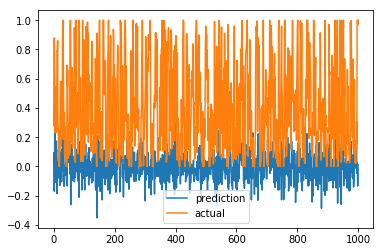

In [51]:
plt.plot(p[0,:,0], label='prediction')
plt.plot(X[0,:,0], label='actual')
plt.legend()

In [43]:
# build decoder model
latent_inputs = Input(shape=(2,), name='z_sampling')
x = Dense(512, activation='relu')(latent_inputs)
outputs = Dense(1000, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              513000    
Total params: 514,536
Trainable params: 514,536
Non-trainable params: 0
_________________________________________________________________


In [53]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= 1
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 1000)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 514564    
_________________________________________________________________
decoder (Model)              (None, 1000)              514536    
Total params: 1,029,100
Trainable params: 1,029,100
Non-trainable params: 0
_________________________________________________________________


In [55]:
vae.fit(X,
        epochs=10,
        batch_size=512,
        validation_split=0.1)

Train on 18 samples, validate on 2 samples
Epoch 1/10
18/18 [==============================] - 0s 569us/step - loss: nan - val_loss: nan
Epoch 2/10
18/18 [==============================] - 0s 578us/step - loss: nan - val_loss: nan
Epoch 3/10
18/18 [==============================] - 0s 454us/step - loss: nan - val_loss: nan
Epoch 4/10
18/18 [==============================] - 0s 530us/step - loss: nan - val_loss: nan
Epoch 5/10
18/18 [==============================] - 0s 468us/step - loss: nan - val_loss: nan
Epoch 6/10
18/18 [==============================] - 0s 535us/step - loss: nan - val_loss: nan
Epoch 7/10
18/18 [==============================] - 0s 509us/step - loss: nan - val_loss: nan
Epoch 8/10
18/18 [==============================] - 0s 601us/step - loss: nan - val_loss: nan
Epoch 9/10
18/18 [==============================] - 0s 523us/step - loss: nan - val_loss: nan
Epoch 10/10
18/18 [==============================] - 0s 508us/step - loss: nan - val_loss: nan
